Warning: this notebook takes about an hour to run on a 2017 MacBook Pro, however the outputs have been saved

In [1]:
#Setting up notebook
%matplotlib notebook

In [2]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

#Import UFSS
import ufss

In [3]:
# these are helper functions defined in ufss for convenient forward and backward dft
# they use pyfftw
ift = ufss.signals.SignalProcessing.ift1D
ft = ufss.signals.SignalProcessing.ft1D

In [5]:
folder = 'circular_test'
os.makedirs(folder,exist_ok=True)

## Constructing the Hamiltonian

In [7]:
# since this system consists of 3 energy levels, we construct three occupation operators:
# Ground state:
n0 = np.zeros((3,3))
n0[0,0] = 1
# first excited state:
n1 = np.zeros((3,3))
n1[1,1] = 1
#second excited state:
n2 = np.zeros((3,3))
n2[2,2] = 1

# the Hamiltonian is given as
epsilon = 0 # energy gap between ground and lowest excited state (rotated away)
depsilon = 1 # energy gap between lowest excited state and next excited state
H = 0*n0 + epsilon * n1 + (epsilon + depsilon) * n2
II = np.eye(H.shape[0]) #Identity of same dimension as H
print(H)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


In [10]:
# Take H and split it into the ground-state manifold (GSM) and the singly-excited manifold (SEM)
H_GSM = H[:1,:1]
H_SEM = H[1:,1:]

# Normally we would now diagonalize H_GSM anad H_SEM separately.  However, they are already diagonal!

# eigenvalues are the diagonal entries of H
eigenvalues = {'0':H_GSM.diagonal(),'1':H_SEM.diagonal()}

# matrix of eigenvectors is simply the identity
eigenvectors = {'0':np.eye(eigenvalues['0'].size),'1':np.eye(eigenvalues['1'].size)}

In order to describe the light-matter interaction, we need to write down the dipole operator.  In order to enforce circular polarization selection rules, we describe the dipole transitions using cartesian coordinates:

In [38]:
# right and left-circularly polarized light are described as
r = np.array([1,-1j,0])/np.sqrt(2)
l = np.conjugate(r)

# we want r to excite from 0 -> 1:
mu_01 = np.array([1,1j,0])/np.sqrt(2)

# we want l to excite from 0 -> 2:
mu_02 = np.array([1,-1j,0])/np.sqrt(2)

mu = np.zeros((3,3,3),dtype='complex')
mu[1,0,:] = mu_01
mu[2,0,:] = mu_02

# Now in principle we should do the following to force mu to be Hermitian
mu_H = mu + np.conjugate(np.transpose(mu,axes=(1,0,2)))
# However, in UFSS, we usually enforce the rotating-wave approximation (RWA) by using what is defined here as
# "mu", and not "mu_H".  mu excites the ket wavefunction, and the complex conjugate transpose of mu de-excites
# the ket wavefunction.  Taking the conjugate transpose is handled automatically in UF2 (may not be implemented
# correctly in RKE yet)

In [35]:
np.einsum('ijk,k',mu,r)

array([[0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j]])

In [39]:
# now a quick test. Begin with initial wavefunction in ground state
psi0 = np.zeros(3)
psi0[0] = 1
mu_dot_e_r = np.einsum('ijk,k',mu,r)
mu_dot_e_l = np.einsum('ijk,k',mu,l)

psi1 = mu_dot_e_r.dot(psi0)
psi2 = mu_dot_e_l.dot(psi0)
print('This should exist only in state 1:',psi1)
print('This should exist only in state 2:',psi2)

This should exist only in state 1: [0.+0.j 1.+0.j 0.+0.j]
This should exist only in state 2: [0.+0.j 0.+0.j 1.+0.j]


In [43]:
# Looks like this has worked!  Now we actually only need the part of mu that connects the GSM to the SEM:
mu_dict = {'0_to_1':mu[1:,:1,:]}

# in this case we can represent psi0 as a vector of length one:
psi0 = np.array([1])

mu_dot_e_r = np.einsum('ijk,k',mu_dict['0_to_1'],r)
mu_dot_e_l = np.einsum('ijk,k',mu_dict['0_to_1'],l)

psi1 = mu_dot_e_r.dot(psi0)
psi2 = mu_dot_e_l.dot(psi0)
print('This should exist only in state 1:',psi1)
print('This should exist only in state 2:',psi2)

This should exist only in state 1: [1.+0.j 0.+0.j]
This should exist only in state 2: [0.+0.j 1.+0.j]


This checks out!  Now to save everything in a format that can be used by the rest of UFSS

In [44]:
np.savez(os.path.join(folder,'eigenvalues'),**eigenvalues)
np.savez(os.path.join(folder,'eigenvectors'),**eigenvectors)
np.savez(os.path.join(folder,'mu'),**mu_dict)

## 2DPE

### Using UF$^2$ to calculate 2DPE

In [46]:
#re is short for rephasing 2DPE
re = ufss.Wavepackets(folder,detection_type='complex_polarization')

In [139]:
# defining the optical pulses in the RWA
sigma = 1
M = 21 # number of points used to resolve optical pulses
Delta = 10 # pulse interval
t = np.linspace(-Delta/2,Delta/2,num=M)
dt = t[1] - t[0]
ef = ufss.gaussian(t,sigma)
c = 0 # center frequency of the laser pulse

# Smallwood et al. use a delta function for the local oscillator
lo_dt = 0.5 #### This must never change, because it defines t and tau, by default
lo_t =  np.arange(-5,5.2,lo_dt)    
lo_dt = lo_t[1] - lo_t[0]
lo = np.zeros(lo_t.size,dtype='float')
lo[lo.size//2] = 1/lo_dt

re.maximum_manifold = 1

re.set_polarization_sequence(['x','x','x','x'])

re.set_efields([t,t,t,lo_t],[ef,ef,ef,lo],[c,c,c,c],[(0,1),(1,0),(1,0)])

re.gamma_res = 20
re.set_t(0.2,dt=1) #set tmax for polarization (only thing here that I think is opaque)
re.pulse_times = [0,0,0]

tau = re.t.copy()[re.t.size//2:] #dtau is the same as the dt for local oscillator
T = np.arange(12,13,1)
re.set_pulse_delays([tau,T])

The following cell will compute the full signal, including all overlap diagrams.  However, that is not what we want here, since Smallwood et al.'s formulas are only for the standard time-ordered diagrams

<IPython.core.display.Javascript object>


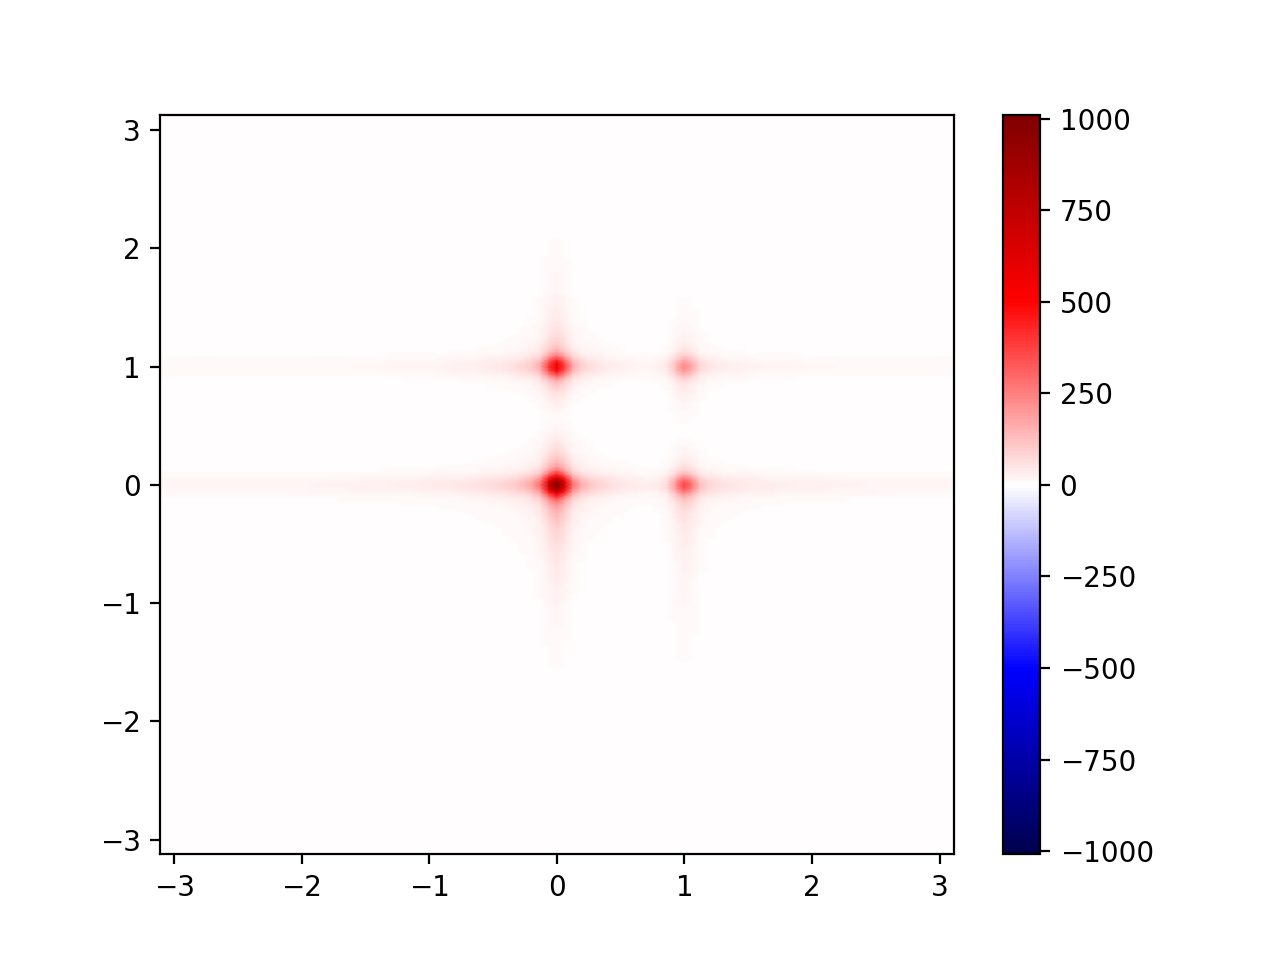

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1837aeeeb8>)

In [140]:
full_sig_tau_T_wt = re.calculate_signal_all_delays()
# the signal returned is the signal as a function of tau, T and the fourier conjugate of t -> omega_t
# inverse fourier transform to get as a function of t:
t, full_sig_tau_T_t = ift(re.w,full_sig_tau_T_wt,axis=2)
# add a gaussian linewidth
blur_sigma = 25
full_sig_tau_T_t *= np.exp(-(tau[:,np.newaxis,np.newaxis])**2/(2*blur_sigma**2))
full_sig_tau_T_t *= np.exp(-(t[np.newaxis,np.newaxis,:])**2/(2*blur_sigma**2))
wtau, full_sig_wtau_T_t = ft(tau,full_sig_tau_T_t,axis=0)
wt, full_sig_wtau_T_wt = ft(t,full_sig_wtau_T_t,axis=2)

# Plot result
ufss.signals.plot2D(wtau,wt,full_sig_wtau_T_wt[:,0,:],part='abs')

<IPython.core.display.Javascript object>


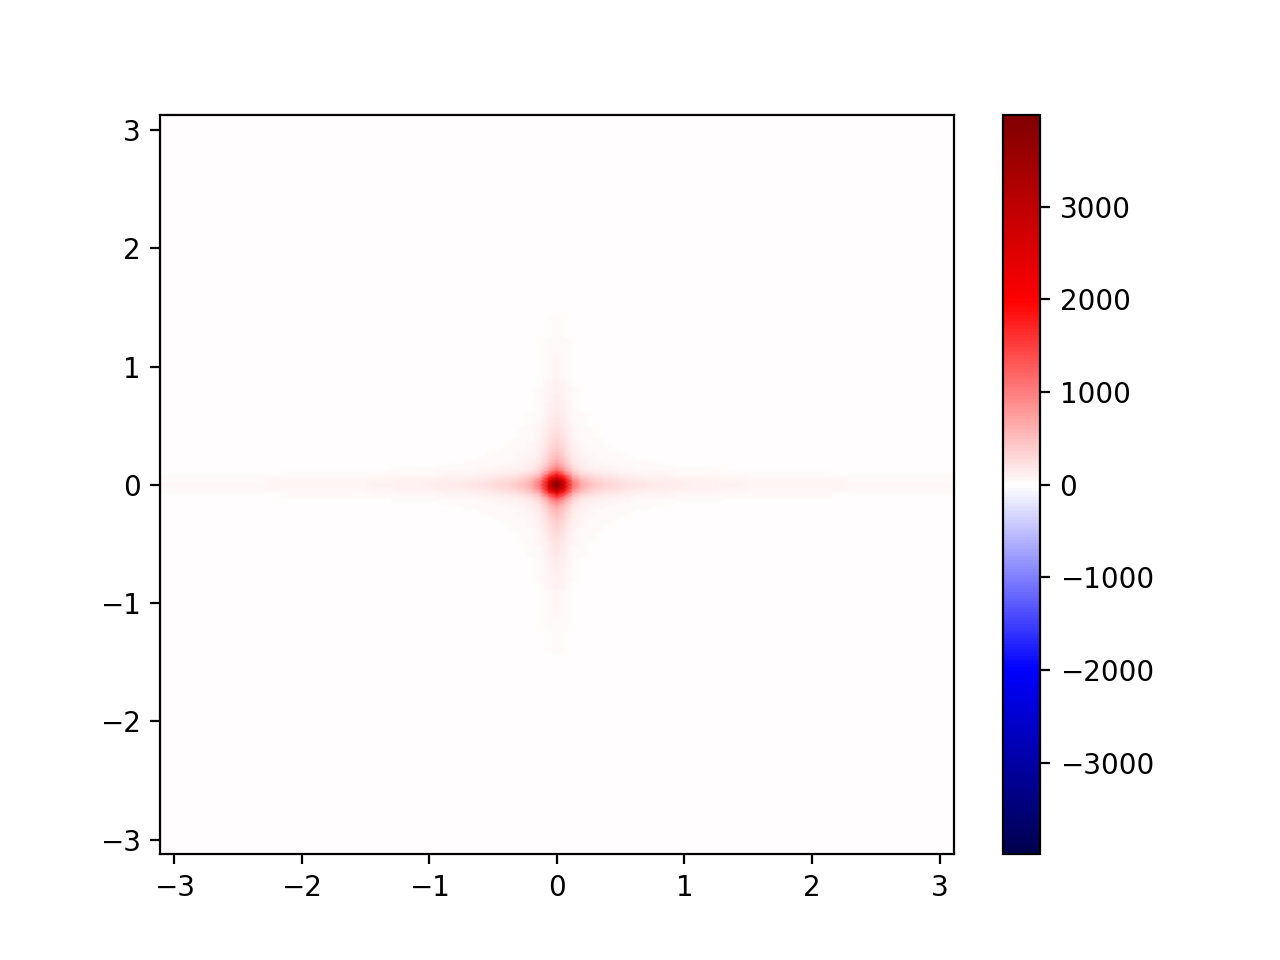

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x183c1bea20>)

In [141]:
re.set_polarization_sequence(['r','r','r','r'])

full_sig_tau_T_wt = re.calculate_signal_all_delays()
# the signal returned is the signal as a function of tau, T and the fourier conjugate of t -> omega_t
# inverse fourier transform to get as a function of t:
t, full_sig_tau_T_t = ift(re.w,full_sig_tau_T_wt,axis=2)
# add a gaussian linewidth
blur_sigma = 25
full_sig_tau_T_t *= np.exp(-(tau[:,np.newaxis,np.newaxis])**2/(2*blur_sigma**2))
full_sig_tau_T_t *= np.exp(-(t[np.newaxis,np.newaxis,:])**2/(2*blur_sigma**2))
wtau, full_sig_wtau_T_t = ft(tau,full_sig_tau_T_t,axis=0)
wt, full_sig_wtau_T_wt = ft(t,full_sig_wtau_T_t,axis=2)

# Plot result
ufss.signals.plot2D(wtau,wt,full_sig_wtau_T_wt[:,0,:],part='abs')

<IPython.core.display.Javascript object>


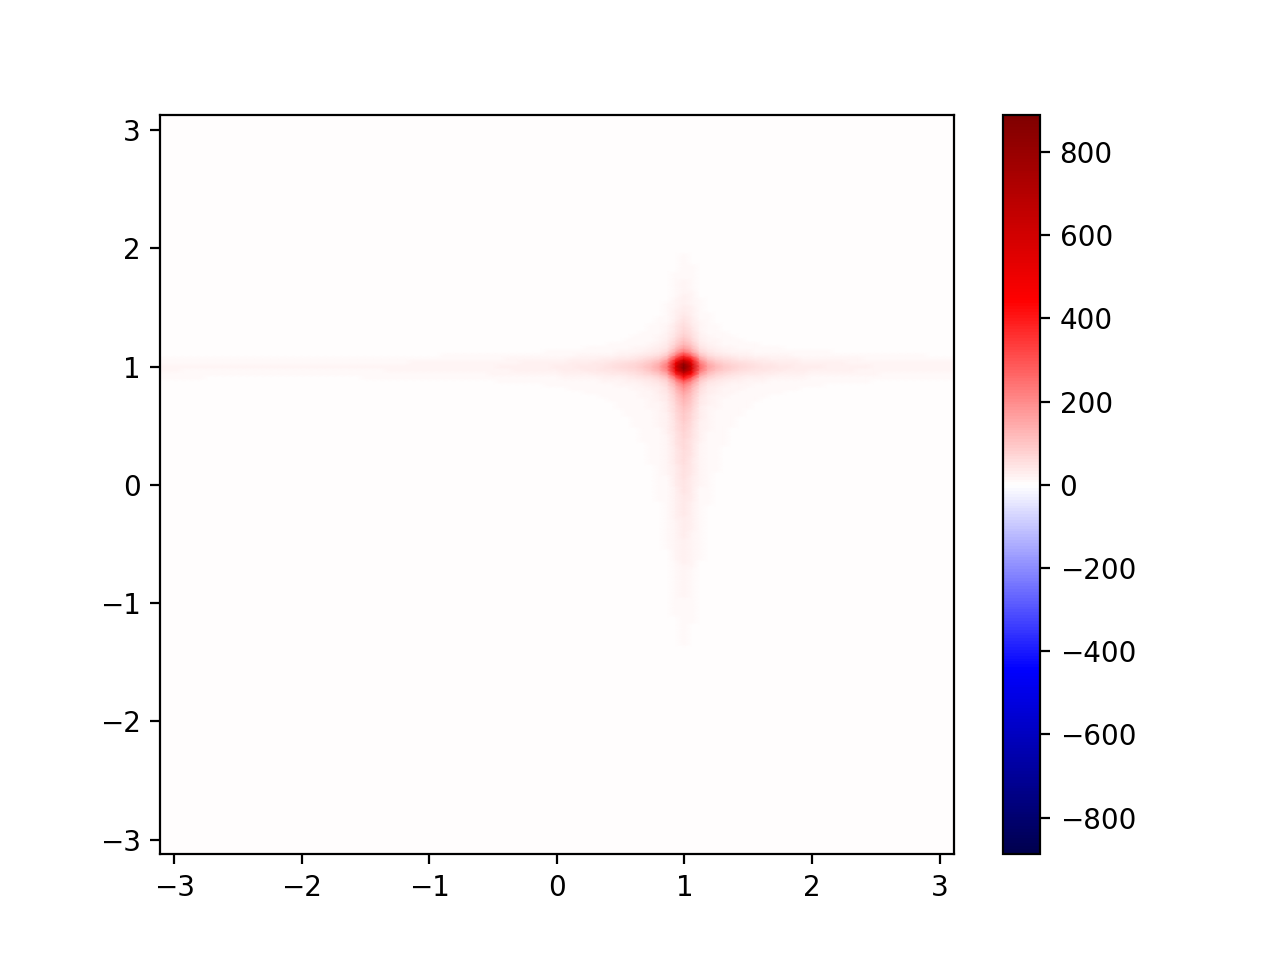

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x183c7db908>)

In [142]:
re.set_polarization_sequence(['l','l','l','l'])

full_sig_tau_T_wt = re.calculate_signal_all_delays()
# the signal returned is the signal as a function of tau, T and the fourier conjugate of t -> omega_t
# inverse fourier transform to get as a function of t:
t, full_sig_tau_T_t = ift(re.w,full_sig_tau_T_wt,axis=2)
# add a gaussian linewidth
blur_sigma = 25
full_sig_tau_T_t *= np.exp(-(tau[:,np.newaxis,np.newaxis])**2/(2*blur_sigma**2))
full_sig_tau_T_t *= np.exp(-(t[np.newaxis,np.newaxis,:])**2/(2*blur_sigma**2))
wtau, full_sig_wtau_T_t = ft(tau,full_sig_tau_T_t,axis=0)
wt, full_sig_wtau_T_wt = ft(t,full_sig_wtau_T_t,axis=2)

# Plot result
ufss.signals.plot2D(wtau,wt,full_sig_wtau_T_wt[:,0,:],part='abs')